In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets albumentations
!pip install evaluate -qq
!pip install torch torchvision torchaudio


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:
from datasets import load_from_disk

#train = load_from_disk('zero_train_v2')
#validation = load_from_disk('zero_valid_v2')

In [ ]:
from datasets import load_dataset

ds = load_dataset("erent/scene_parse_5class")
ds = ds["train"]

train = ds.train_test_split(test_size=0.2)['train']
validation = ds.train_test_split(test_size=0.2)['test']

In [3]:
import random 
import numpy as np

np.unique(train[122]["annotation"])

array([ 0,  2,  6, 10], dtype=uint8)

In [5]:
!wget https://raw.githubusercontent.com/CSAILVision/placeschallenge/master/instancesegmentation/instanceInfo100_train.txt
import pandas as pd

data = pd.read_csv('instanceInfo100_train.txt',
                   sep='\t', header=0, on_bad_lines="skip")
id2label = {id: label.strip() for id, label in enumerate(data["Object Names"])}
print(id2label)

{0: 'bed', 1: 'windowpane', 2: 'cabinet', 3: 'person', 4: 'door', 5: 'table', 6: 'curtain', 7: 'chair', 8: 'car', 9: 'painting', 10: 'sofa', 11: 'shelf', 12: 'mirror', 13: 'armchair', 14: 'seat', 15: 'fence', 16: 'desk', 17: 'wardrobe', 18: 'lamp', 19: 'bathtub', 20: 'railing', 21: 'cushion', 22: 'box', 23: 'column', 24: 'signboard', 25: 'chest of drawers', 26: 'counter', 27: 'sink', 28: 'fireplace', 29: 'refrigerator', 30: 'stairs', 31: 'case', 32: 'pool table', 33: 'pillow', 34: 'screen door', 35: 'bookcase', 36: 'coffee table', 37: 'toilet', 38: 'flower', 39: 'book', 40: 'bench', 41: 'countertop', 42: 'stove', 43: 'palm', 44: 'kitchen island', 45: 'computer', 46: 'swivel chair', 47: 'boat', 48: 'arcade machine', 49: 'bus', 50: 'towel', 51: 'light', 52: 'truck', 53: 'chandelier', 54: 'awning', 55: 'streetlight', 56: 'booth', 57: 'television receiver', 58: 'airplane', 59: 'apparel', 60: 'pole', 61: 'bannister', 62: 'ottoman', 63: 'bottle', 64: 'van', 65: 'ship', 66: 'fountain', 67: 'w

## Create PyTorch Dataset

Now that we've shown how a single example gets prepared, we can define a general PyTorch Dataset. This dataset will return any given training example, entirely prepared for the model.

In [6]:
import torch
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, processor, transform=None):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = np.array(self.dataset[idx]["image"].convert("RGB"))

        instance_seg = np.array(self.dataset[idx]["annotation"])
        class_id_map = np.array(self.dataset[idx]["annotation"])
        class_labels = np.unique(class_id_map)

        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == label])
            inst2class.update({i: label for i in instance_ids})

        # apply transforms
        if self.transform is not None:
            transformed = self.transform(image=image, mask=instance_seg)
            image, instance_seg = transformed['image'], transformed['mask']
            # convert to C, H, W
            image = image.transpose(2,0,1)

        if class_labels.shape[0] == 1 and class_labels[0] == 0:
            # Some image does not have annotation (all ignored)
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k:v.squeeze() for k,v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros((0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1]))
        else:
          inputs = self.processor([image], [instance_seg], instance_id_to_semantic_id=inst2class, return_tensors="pt")
          inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}

        return inputs

In [7]:
from transformers import MaskFormerImageProcessor

processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)

2024-07-22 05:25:17.954862: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
import numpy as np
import albumentations as A

ADE_MEAN = np.array([0.485, 0.456, 0.406])
ADE_STD = np.array([0.229, 0.224, 0.225])

# Convert mean and std from NumPy arrays to lists
ADE_MEAN = ADE_MEAN.tolist()
ADE_STD = ADE_STD.tolist()

# note that you can include more fancy data augmentation methods here
train_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

train_dataset = ImageSegmentationDataset(train, processor=processor, transform=train_transform)
validation_dataset = ImageSegmentationDataset(validation, processor=processor, transform=train_transform)


In [9]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    return {"pixel_values": pixel_values, "pixel_mask": pixel_mask, "class_labels": class_labels, "mask_labels": mask_labels}

train_dataloader = DataLoader(train_dataset, batch_size=14, shuffle=True, collate_fn=collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=14, shuffle=True, collate_fn=collate_fn)


In [10]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

pixel_values torch.Size([14, 3, 512, 512])
pixel_mask torch.Size([14, 512, 512])
class_labels 14
mask_labels 14


## Define the model

Next, let's define the model. Here we will only replace the classification head with a new one, all other parameters will use pre-trained ones.

In [21]:
from transformers import MaskFormerForInstanceSegmentation

# Replace the head of the pre-trained model
# We specify ignore_mismatched_sizes=True to replace the already fine-tuned classification head by a new one
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([101, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([101]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us that we're throwing away the classification head and randomly initializing a new one.

In [16]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

pixel_values torch.Size([14, 3, 512, 512])
pixel_mask torch.Size([14, 512, 512])
class_labels 14
mask_labels 14


In [17]:
print([label.shape for label in batch["class_labels"]])

[torch.Size([5]), torch.Size([3]), torch.Size([4]), torch.Size([4]), torch.Size([2]), torch.Size([2]), torch.Size([3]), torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([5]), torch.Size([3]), torch.Size([2]), torch.Size([2])]


In [18]:
print([label.shape for label in batch["mask_labels"]])

[torch.Size([5, 512, 512]), torch.Size([3, 512, 512]), torch.Size([4, 512, 512]), torch.Size([4, 512, 512]), torch.Size([2, 512, 512]), torch.Size([2, 512, 512]), torch.Size([3, 512, 512]), torch.Size([4, 512, 512]), torch.Size([4, 512, 512]), torch.Size([4, 512, 512]), torch.Size([5, 512, 512]), torch.Size([3, 512, 512]), torch.Size([2, 512, 512]), torch.Size([2, 512, 512])]


## Train the model

Let's train the model in familiar PyTorch fashion.

In [22]:
import torch
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

running_loss = 0.0
num_samples = 0
for epoch in range(15):
    print("Epoch:", epoch)
    model.train()
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # Reset the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            pixel_values=batch["pixel_values"].to(device),
            mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
            class_labels=[labels.to(device) for labels in batch["class_labels"]],
        )

        # Backward propagation
        loss = outputs.loss
        loss.backward()

        batch_size = batch["pixel_values"].size(0)
        running_loss += loss.item()
        num_samples += batch_size

        if idx % 100 == 0:
            print("Loss:", running_loss/num_samples)

        # Optimization
        optimizer.step()


Epoch: 0


  0%|          | 0/109 [00:00<?, ?it/s]

Loss: 0.5043366295950753
Loss: 0.1243763930642453
Epoch: 1


  0%|          | 0/109 [00:00<?, ?it/s]

Loss: 0.12016147437520053
Loss: 0.08449088328115927
Epoch: 2


  0%|          | 0/109 [00:00<?, ?it/s]

Loss: 0.0828544671091886
Loss: 0.06849110453904936


In [19]:
from transformers import MaskFormerImageProcessor

processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=True, do_rescale=True, do_normalize=True)

In [22]:
### Load Mean IoU metric
import evaluate
from tqdm.auto import tqdm

metrics = evaluate.load("mean_iou")
# Set model in evaluation mode
model.eval()
# Test set doesn't have annotations so we will use the validation set
ground_truths, preds = [], []
for idx in tqdm(range(len(validation))):
    image = validation[idx]["image"].convert("RGB")
    target_size = image.size[::-1]
    # Get ground truth semantic segmentation map
    annotation = np.array(validation[idx]["annotation"])
    # Replace null class (0) with the ignore_index (255) and reduce labels
    annotation[annotation==0] = 255
    ground_truths.append(annotation)
    # Preprocess image
    inputs = processor(images=image, return_tensors="pt").to(device)
    # Inference
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
 
    # Post-process results to retrieve semantic segmentation maps
    result = processor.post_process_semantic_segmentation(outputs, target_sizes=[target_size])[0]
    semantic_seg_mask = result.cpu().detach().numpy()
    preds.append(semantic_seg_mask)
results = metrics.compute(
    predictions=preds,
    references=ground_truths,
    num_labels=99,
    ignore_index=255
)
print(f"Mean IoU: {results['mean_iou']} | Mean Accuracy: {results['mean_accuracy']} | Overall Accuracy: {results['overall_accuracy']}")

  0%|          | 0/367 [00:00<?, ?it/s]

Mean IoU: 0.6967773955093214 | Mean Accuracy: 0.8519806365954373 | Overall Accuracy: 0.8644750134353631


In [25]:
# Prepare the output
scores = results["per_category_accuracy"]
class_id = -1
for score in scores:  # Adjust 'start=1' based on your id2label indexing
    class_id = class_id + 1
    if np.isnan(score):
        # Option to skip NaN values
        continue
 
    if class_id:

        class_name = id2label.get(class_id, "Unknown Class")
        print(f"Class ID: {class_id}, Class Name: {class_name}, Score: {score}")

Class ID: 2, Class Name: cabinet, Score: 0.8674239089256615
Class ID: 4, Class Name: door, Score: 0.9203891943882269
Class ID: 5, Class Name: table, Score: 0.8496349066581836
Class ID: 6, Class Name: curtain, Score: 0.8183885366153354
Class ID: 10, Class Name: sofa, Score: 0.8040666363897798


In [28]:
from transformers import MaskFormerImageProcessor

processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=True, do_rescale=True, do_normalize=True)

The predictions include 2 things, a predicted segmentation map and a corresponding segments_info, which includes more information about the segments of the map.

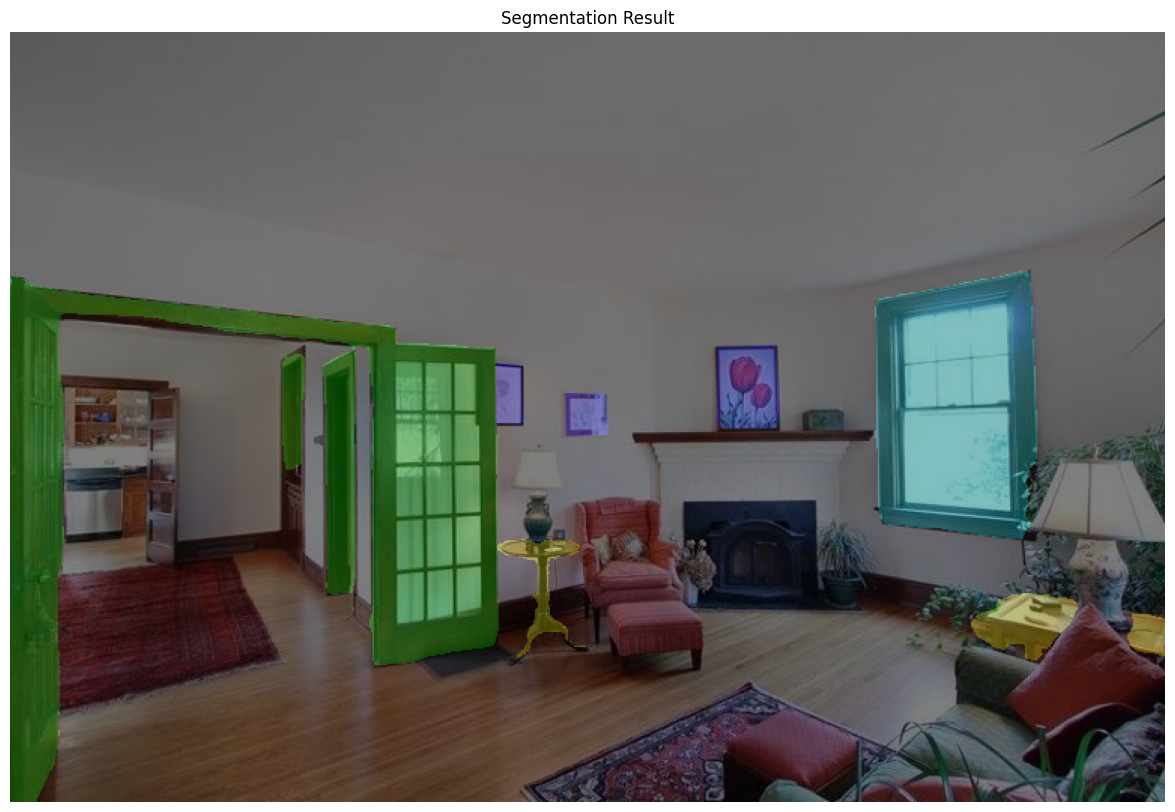

Class ID to Color and Name Mapping:
Class ID: 2, Color: cyan, Name: windowpane
Class ID: 4, Color: red, Name: person
Class ID: 5, Color: green, Name: door
Class ID: 6, Color: yellow, Name: table
Class ID: 10, Color: blue, Name: painting


In [169]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define your custom colors for the classes
custom_palette = {
    #0: [0, 0, 0],     
    2: [0, 128, 128],  
    4: [128, 0, 0],    
    5: [0, 128, 0],   
    6: [128, 128, 0],  
    10: [0, 0, 128],   
}
custom_names = {
    #0: "back",   
    2: "cyan",    
    4: "red",     
    5: "green",   
    6: "yellow",  
    10: "blue",   
}

# Use a random test image
image_index = random.randint(0, len(validation) - 1)
image = validation[image_index]["image"].convert("RGB")
target_size = image.size[::-1]

# Preprocess image
inputs = processor(images=image, return_tensors="pt").to(device)

# Inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs.to(device))

predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

# Visualization
seg = predicted_semantic_map.cpu().detach().numpy()
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)

# Apply the custom color palette
for label, color in custom_palette.items():
    color_seg[seg == label, :] = color

# Show image + mask
image_np = np.array(image)
blended_img = Image.blend(Image.fromarray(image_np), Image.fromarray(color_seg), alpha=0.5)

plt.figure(figsize=(15, 10))
plt.imshow(blended_img)
plt.title("Segmentation Result")
plt.axis('off')
plt.show()

# Print class ID to color and name mapping
print("Class ID to Color and Name Mapping:")
for class_id, color in custom_palette.items():
    if class_id == 0: 
        continue
    print(f"Class ID: {class_id}, Color: {custom_names[class_id]}, Name: {id2label[class_id-1]}")

